# Open Ocean
# Open Earth Fundation
---------------------------------------------------------------------------------------------------------------------
Author: Ando Shah

---------------------------------------------------------------------------------------------------------------------

# Gridded Version of WEGE Scores for AMMB in Costa Rica

In this notebook, we will calculate the WEGE scores on a gridded basis, following this algorithm:

1. Get all IUCN listed species within the AMMB region
2. Grid the world at a given resolution (in degrees, for now)
3. Generate a dataframe that has the following:
    a. Every row contains a unique species
    b. Every row contains a geometry that is composed of a list of grids (at the resolution slected in the previous step), where that species exists in the world
    


## Data needed for this project

<h2> Data needed for this project </h2>

The data was output by `ACMC_IUCN_step1_curatedata.ipynb` and can be found under [IUCN_RedList](https://drive.google.com/drive/folders/1nkw8VK9mPdthjyDOSsnljqCo_b7lMdP4?usp=sharing) under a temporary folder that accompagnies the GitHub repository: 

`Ocean Program > data > to download for gh > ACMC_IUCN_data`

In [54]:
import geopandas as gpd

In [55]:
import numpy as np
import pandas as pd

In [56]:
import os
import glob

In [57]:
from shapely.geometry import Polygon, Point, MultiPolygon

In [58]:
import fiona; #help(fiona.open)

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
!pip install h3

In [61]:
import h3

In [62]:
import sys  
sys.path.insert(0, '../')
from grid_utils import *

In [63]:
import warnings
warnings.filterwarnings("ignore")

## Step 1

Iterate over all IUCN listed species in the AMMB. For each species, create h3 grids for it's entire range (at specified global resolution), and add a column that counts the total number of grids that that species occupies.

Read in AMMB GIS and IUCN data

In [64]:
AMMB_species = gpd.read_file('AMMB_IUCN_data/gdf_AMMB_IUCN_range_status_filtered.shp')#, rows=10) 

In [65]:
len(AMMB_species)

164

In [87]:
ACMC = gpd.read_file("AMMB_IUCN_data/geospatial_input/ACMC.shp")

<AxesSubplot:>

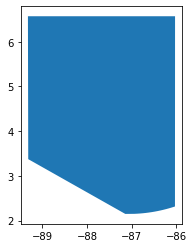

In [88]:
ACMC.plot()

## But first, Dask it up

In [67]:
import pystac_client
import matplotlib.pyplot as plt
import dask.dataframe as dd
import planetary_computer
import dask_geopandas as dgpd

import dask_gateway

# cluster = None
gateway = dask_gateway.Gateway()
cluster_options = gateway.cluster_options()

### Dask Helpers

In [68]:
def check_for_existing_clusters():
    if len(gateway.list_clusters()) == 0:
        return False   
    return True

#max is 227
def setup_dask_cluster(min=2, max=227, mem=16):
    cluster_options["worker_memory"] = mem
    
    if check_for_existing_clusters():
        print ("Clusters already exist, latching onto the first one")
        
        clusters = gateway.list_clusters()
        cluster = gateway.connect(clusters[0].name)
        
        client = cluster.get_client()
        
    else :
        cluster = gateway.new_cluster(cluster_options, shutdown_on_close=False)
        client = cluster.get_client()
        cluster.adapt(minimum=min, maximum=max)
    
    
    print(client)
    print(cluster.dashboard_link)

    
def shutdown_all_clusters():
    
    clusters = gateway.list_clusters()
    if clusters is not None:
        for c in clusters:
            cluster = gateway.connect(c.name)
            cluster.shutdown()
            print (cluster)
    
# This function will be used to 'override' dask.conpute
# check if dask clusters are alive, if so, latch onto it
# otherwise spawn a new cluster and do .compute on df
def compute(ddf):
    setup_dask_cluster()
    return ddf.compute()

def dashboard():
    return cluster.dashboard_link

In [69]:
setup_dask_cluster()
# ddf_h3 = dgpd.from_geopandas(df_h3, npartitions=50)
#To bypass dask when gateway is down
AMMB_species_grid = dgpd.from_geopandas(AMMB_species, npartitions=len(AMMB_species))
AMMB_species_grid

Clusters already exist, latching onto the first one
<Client: 'tls://10.244.8.8:8786' processes=3 threads=3, memory=48.00 GiB>
https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.c7b1da59112e453f817f67c43321cc6c/status


,ASSESSMENT,ID_NO,BINOMIAL,PRESENCE,ORIGIN,SEASONAL,COMPILER,YEAR,CITATION,LEGEND,SUBSPECIES,SUBPOP,DIST_COMM,ISLAND,TAX_COMM,redlistCat,scientific,geometry
npartitions=163,,,,,,,,,,,,,,,,,,
0,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,geometry
1,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [70]:
#AMMB_species_grid = AMMB_species_partial.copy()
#AMMB_species_grid

In [71]:
AMMB_species_grid.length

Dask Series Structure:
npartitions=163
0      float64
1          ...
        ...   
162        ...
163        ...
dtype: float64
Dask Name: length, 326 tasks

### H3 Gridding

In [72]:
h3_resolution = 3

In [73]:
# for row in AMMB_species_grid.itertuples():

# df_h3 = gpd.GeoDataFrame(columns=['ID_NO','gridcount','resolution'], crs="EPSG:4326")

# for row in AMMB_species_grid.itertuples(): 
  
#     multi_polygon = row.geometry
#     taxon_id = row.ID_NO
    
#     z = [] #holds the list of polygons per species

#     for polygon in multi_polygon:
#         # Convert Polygon to GeoJSON dictionary
#         poly_geojson = gpd.GeoSeries([polygon]).__geo_interface__
#         # Parse out geometry key from GeoJSON dictionary
#         poly_geojson = poly_geojson['features'][0]['geometry'] 
#         # Fill the dictionary with Resolution 10 H3 Hexagons
#         h3_hexes = h3.polyfill_geojson(poly_geojson, h3_resolution) 
#         # display(h3_hexes)
        
#         polygonise = lambda hex_id: Polygon(h3.h3_to_geo_boundary(hex_id, geo_json=True))
#         z.append(list(map(polygonise, h3_hexes)))
        
    
#     all_polygons = []
#     #Flatten list
#     for x in z:
#         for y in x:
#             all_polygons.append(y)
            
#     count = len(all_polygons) #number of grid cells

#     m = MultiPolygon(all_polygons)
    
#     df = gpd.GeoDataFrame({'ID_NO':[taxon_id],'gridcount':count, 'resolution':h3_resolution}, geometry=[m], crs="EPSG:4326")
    
#     df_h3 = pd.concat([df_h3, df],ignore_index=True)

In [74]:
import collections

def flatten(x):
    if isinstance(x, collections.Iterable):
        return [a for i in x for a in flatten(i)]
    else:
        return [x]

In [75]:
## Solution from
## https://towardsdatascience.com/around-the-world-in-80-lines-crossing-the-antimeridian-with-python-and-shapely-c87c9b6e1513

from typing import Union, List, Generator
from shapely.geometry import mapping, Polygon, GeometryCollection
from shapely import affinity
import math
import copy
import json
from typing import Union, List
from shapely.geometry import Polygon, LineString, GeometryCollection
from shapely.ops import split


def check_crossing(lon1: float, lon2: float, validate: bool = False, dlon_threshold: float = 180.0):
    """
    Assuming a minimum travel distance between two provided longitude coordinates,
    checks if the 180th meridian (antimeridian) is crossed.
    """

    if validate and any([abs(x) > 180.0 for x in [lon1, lon2]]):
        raise ValueError("longitudes must be in degrees [-180.0, 180.0]")   
    return abs(lon2 - lon1) > dlon_threshold

def translate_polygons(geometry_collection: GeometryCollection, 
                       output_format: str = "geojson") -> Generator[
                          Union[List[dict], List[Polygon]], None, None
                       ]:
    
  for polygon in geometry_collection:
      (minx, _, maxx, _) = polygon.bounds
      if minx < -180: geo_polygon = affinity.translate(polygon, xoff = 360)
      elif maxx > 180: geo_polygon = affinity.translate(polygon, xoff = -360)
      else: geo_polygon = polygon

      yield_geojson = output_format == "geojson"
      yield json.dumps(mapping(geo_polygon)) if (yield_geojson) else geo_polygon
    
def split_polygon(geojson: dict, output_format: str = "geojson", validate: bool = False) -> Union[
    List[dict], List[Polygon], GeometryCollection
    ]:
    """
    Given a GeoJSON representation of a Polygon, returns a collection of
    'antimeridian-safe' constituent polygons split at the 180th meridian, 
    ensuring compliance with GeoJSON standards (https://tools.ietf.org/html/rfc7946#section-3.1.9)
    Assumptions:
      - Any two consecutive points with over 180 degrees difference in
        longitude are assumed to cross the antimeridian
      - The polygon spans less than 360 degrees in longitude (i.e. does not wrap around the globe)
      - However, the polygon may cross the antimeridian on multiple occasions
    Parameters:
        geojson (dict): GeoJSON of input polygon to be split. For example:
                        {
                        "type": "Polygon",
                        "coordinates": [
                          [
                            [179.0, 0.0], [-179.0, 0.0], [-179.0, 1.0],
                            [179.0, 1.0], [179.0, 0.0]
                          ]
                        ]
                        }
        output_format (str): Available options: "geojson", "polygons", "geometrycollection"
                             If "geometrycollection" returns a Shapely GeometryCollection.
                             Otherwise, returns a list of either GeoJSONs or Shapely Polygons
        validate (bool): Checks if all longitudes are within [-180.0, 180.0]
      
    Returns:
        List[dict]/List[Polygon]/GeometryCollection: antimeridian-safe polygon(s)
    """
    output_format = output_format.replace("-", "").strip().lower()
    coords_shift = copy.deepcopy(geojson["coordinates"])
    
    shell_minx = shell_maxx = None
    split_meridians = set()
    splitter = None

    for ring_index, ring in enumerate(coords_shift):
        if len(ring) < 1: 
            continue
        else:
            ring_minx = ring_maxx = ring[0][0]
            crossings = 0

        for coord_index, (lon, _) in enumerate(ring[1:], start=1):
            lon_prev = ring[coord_index - 1][0] # [0] corresponds to longitude coordinate
            if check_crossing(lon, lon_prev, validate=validate):
                direction = math.copysign(1, lon - lon_prev)
                coords_shift[ring_index][coord_index][0] = lon - (direction * 360.0)
                crossings += 1

            x_shift = coords_shift[ring_index][coord_index][0]
            if x_shift < ring_minx: ring_minx = x_shift
            if x_shift > ring_maxx: ring_maxx = x_shift

        # Ensure that any holes remain contained within the (translated) outer shell
        if (ring_index == 0): # by GeoJSON definition, first ring is the outer shell
            shell_minx, shell_maxx = (ring_minx, ring_maxx)
        elif (ring_minx < shell_minx):
            ring_shift = [[x + 360, y] for (x, y) in coords_shift[ring_index]]
            coords_shift[ring_index] = ring_shift
            ring_minx, ring_maxx = (x + 360 for x in (ring_minx, ring_maxx))
        elif (ring_maxx > shell_maxx):
            ring_shift = [[x - 360, y] for (x, y) in coords_shift[ring_index]]
            coords_shift[ring_index] = ring_shift
            ring_minx, ring_maxx = (x - 360 for x in (ring_minx, ring_maxx))

        if crossings: # keep track of meridians to split on
            if ring_minx < -180: split_meridians.add(-180)
            if ring_maxx > 180: split_meridians.add(180)

    n_splits = len(split_meridians)
    if n_splits > 1:
        raise NotImplementedError(
            """Splitting a Polygon by multiple meridians (MultiLineString) 
               not supported by Shapely"""
        )
    elif n_splits == 1:
        split_lon = next(iter(split_meridians))
        meridian = [[split_lon, -90.0], [split_lon, 90.0]]
        splitter = LineString(meridian)

    shell, *holes = coords_shift if splitter else geojson["coordinates"]
    if splitter: split_polygons = split(Polygon(shell, holes), splitter)
    else: split_polygons = GeometryCollection([Polygon(shell, holes)])
        
    geo_polygons = list(translate_polygons(split_polygons, output_format))  
    if output_format == "geometrycollection": return GeometryCollection(geo_polygons)
    else: return geo_polygons

In [76]:
def h3_grid(gdf, h3_resolution = 3, fix=True, right_hand_check = False):
    
    if right_hand_check:
        gdf.geometry = gdf.geometry.apply(orient, args=(-1.0,))
    
    h3_gdf = gpd.GeoDataFrame(columns=['ID_NO','gridcount','resolution'], crs="EPSG:4326")

    for row in gdf.itertuples(): 

        multi_polygon = row.geometry
        taxon_id = row.ID_NO

        z = [] #holds the list of polygons per row


        for polygon in multi_polygon:

            # Convert Polygon to GeoJSON dictionary, parse out geometry key from GeoJSON dictionary
            poly_geojson = gpd.GeoSeries([polygon]).__geo_interface__['features'][0]['geometry'] 
            # Parse out geometry key from GeoJSON dictionary
            # poly_geojson = poly_geojson['features'][0]['geometry'] 
            # Fill the dictionary with Resolution 'h3_res' H3 Hexagons
            h3_hexes = h3.polyfill_geojson(poly_geojson, h3_resolution) 
            # display(h3_hexes)

            polygonise = lambda hex_id: Polygon(h3.h3_to_geo_boundary(hex_id, geo_json=True))
            z.append(list(map(polygonise, h3_hexes)))


        all_polygons = []
        all_fixed_polygons = []
        all_fixed_polygons_flat = []
        #Flatten list
        all_polygons = flatten(z)
                
        count = len(all_polygons) #number of grid cells
                
        if fix:
            for p in all_polygons:
                # print(p)
                poly_gpd = gpd.GeoSeries([p]).__geo_interface__
                #json.dumps converts to geojson format (with the right square brackets, etc), but outputs a string
                #json.loads converts it back to a dictionary
                poly_geojson = json.loads(json.dumps(poly_gpd['features'][0]['geometry']))
                #split if it crosses the antimeridian
                all_fixed_polygons.append(split_polygon(poly_geojson, 'polygons'))
                

        #Flatten all_fixed_polygons
        all_fixed_polygons_flat = flatten(all_fixed_polygons)

        m = MultiPolygon(all_fixed_polygons_flat)
        df_temp = dgpd.GeoDataFrame({'ID_NO':[taxon_id],'gridcount':count, 'resolution':h3_resolution}, geometry=[m], crs="EPSG:4326")
        # df_temp = gpd.GeoDataFrame({'gridcount':count, 'resolution':h3_resolution}, geometry=[m], crs="EPSG:4326")
        h3_gdf = pd.concat([h3_gdf, df_temp],ignore_index=True)
                    
                    
    return h3_gdf

In [77]:
##Dask heavy version
# def h3_grid(gdf, h3_resolution = 3, fix=True, right_hand_check = False):
    
#     if right_hand_check:
#         gdf.geometry = gdf.geometry.apply(orient, args=(-1.0,))
    
#     h3_gdf = gpd.GeoDataFrame(columns=['ID_NO','gridcount','resolution'], crs="EPSG:4326")
#     h3_dgdf = dgpd.from_geopandas(h3_gdf, npartitions=len(gdf))
    
#     for row in gdf.itertuples(): 

#         multi_polygon = row.geometry
#         taxon_id = row.ID_NO

#         z = [] #holds the list of polygons per row


#         for polygon in multi_polygon:

#             # Convert Polygon to GeoJSON dictionary, parse out geometry key from GeoJSON dictionary
#             poly_geojson = gpd.GeoSeries([polygon]).__geo_interface__['features'][0]['geometry'] 
#             # Parse out geometry key from GeoJSON dictionary
#             # poly_geojson = poly_geojson['features'][0]['geometry'] 
#             # Fill the dictionary with Resolution 'h3_res' H3 Hexagons
#             h3_hexes = h3.polyfill_geojson(poly_geojson, h3_resolution) 
#             # display(h3_hexes)

#             polygonise = lambda hex_id: Polygon(h3.h3_to_geo_boundary(hex_id, geo_json=True))
#             z.append(list(map(polygonise, h3_hexes)))


#         all_polygons = []
#         all_fixed_polygons = []
#         all_fixed_polygons_flat = []
#         #Flatten list
#         all_polygons = flatten(z)
                
#         count = len(all_polygons) #number of grid cells
                
#         if fix:
#             for p in all_polygons:
#                 # print(p)
#                 poly_gpd = gpd.GeoSeries([p]).__geo_interface__
#                 #json.dumps converts to geojson format (with the right square brackets, etc), but outputs a string
#                 #json.loads converts it back to a dictionary
#                 poly_geojson = json.loads(json.dumps(poly_gpd['features'][0]['geometry']))
#                 #split if it crosses the antimeridian
#                 all_fixed_polygons.append(split_polygon(poly_geojson, 'polygons'))
                

#         #Flatten all_fixed_polygons
#         all_fixed_polygons_flat = flatten(all_fixed_polygons)

#         m = MultiPolygon(all_fixed_polygons_flat)
#         df_temp = dgpd.GeoDataFrame({'ID_NO':[taxon_id],'gridcount':count, 'resolution':h3_resolution}, geometry=[m], crs="EPSG:4326")
#         # df_temp = gpd.GeoDataFrame({'gridcount':count, 'resolution':h3_resolution}, geometry=[m], crs="EPSG:4326")
#         h3_gdf = pd.concat([h3_gdf, df_temp],ignore_index=True)
                    
                    
#     return h3_gdf

In [78]:
import h3
def h3fy(geom, h3_resolution = 3, fix=True, right_hand_check = False):
# def h3fy(row, h3_resolution = 3, fix=True, right_hand_check = False):
    
    # geom = row.geometry
    
    if right_hand_check:
        geom = geom.apply(orient, args=(-1.0,))
    
    z = [] #holds the list of polygons per row

    for polygon in geom:

        #TODO: Make this shenanigan more efficient!
        # Convert Polygon to GeoJSON dictionary
        poly_geojson = gpd.GeoSeries([polygon]).__geo_interface__
        # Parse out geometry key from GeoJSON dictionary
        poly_geojson = poly_geojson['features'][0]['geometry'] 
        # Fill the dictionary with Resolution 'h3_res' H3 Hexagons
        h3_hexes = h3.polyfill_geojson(poly_geojson, h3_resolution) 
        # display(h3_hexes)
        polygonise = lambda hex_id: Polygon(h3.h3_to_geo_boundary(hex_id, geo_json=True))
        z.append(list(map(polygonise, h3_hexes)))


    all_polygons = []
    all_fixed_polygons = []
    all_fixed_polygons_flat = []
    #Flatten list
    all_polygons = flatten(z)

    count = len(all_polygons) #number of grid cells

    if fix:
        for p in all_polygons:
            # print(p)
            poly_gpd = gpd.GeoSeries([p]).__geo_interface__

            #json.dumps converts to geojson format (with the right square brackets, etc), but outputs a string
            #json.loads converts it back to a dictionary
            poly_geojson = json.loads(json.dumps(poly_gpd['features'][0]['geometry']))
            #split if it crosses the antimeridian
            all_fixed_polygons.append(split_polygon(poly_geojson, 'polygons'))


    #Flatten all_fixed_polygons
    all_fixed_polygons_flat = flatten(all_fixed_polygons)
    m = MultiPolygon(all_fixed_polygons_flat)
    return m
    # return row.geometry


## Compute intensive Geopandas method

In [80]:
%time df_h3 = AMMB_species.set_geometry(AMMB_species.geometry.apply(h3fy))
df_h3

CPU times: user 1h 52min 2s, sys: 10.2 s, total: 1h 52min 13s
Wall time: 1h 52min 4s


,ASSESSMENT,ID_NO,BINOMIAL,PRESENCE,ORIGIN,SEASONAL,COMPILER,YEAR,CITATION,LEGEND,SUBSPECIES,SUBPOP,DIST_COMM,ISLAND,TAX_COMM,redlistCat,scientific,geometry
0,1506081,177969,Acanthurus nigricans,1,1,1,Jonnell Sanciangco,2010,International Union for Conservation of Nature...,Extant (resident),None,None,None,None,None,Least Concern,Acanthurus nigricans,"MULTIPOLYGON (((115.43220 -20.44967, 115.54126..."
1,1512439,177988,Naso annulatus,1,1,1,Jonnell Sanciangco,2010,International Union for Conservation of Nature...,Extant (resident),None,None,None,None,None,Least Concern,Naso annulatus,"MULTIPOLYGON (((106.95906 -2.10069, 106.81441 ..."
2,1517273,178002,Naso hexacanthus,1,1,1,Jonnell Sanciangco,2010,International Union for Conservation of Nature...,Extant (resident),None,None,None,None,None,Least Concern,Naso hexacanthus,"MULTIPOLYGON (((94.58064 13.36498, 94.39824 14..."
3,2412930,195754,Gymnothorax meleagris,1,1,1,IUCN Marine Biodiversity Unit/GMSA,2018,IUCN Marine Biodiversity Unit/GMSA,Extant (resident),None,None,None,None,None,Least Concern,Gymnothorax meleagris,"MULTIPOLYGON (((94.58064 13.36498, 94.39824 14..."
4,2423479,195824,Uropterygius macrocephalus,1,1,1,IUCN Marine Biodiversity Unit/GMSA,2018,IUCN Marine Biodiversity Unit/GMSA,Extant (resident),None,None,None,None,None,Least Concern,Uropterygius macrocephalus,"MULTIPOLYGON (((124.21405 26.62850, 124.33485 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,156932432,22563,Tursiops truncatus,1,1,1,IUCN,2019,IUCN (International Union for Conservation of ...,Extant (resident),None,None,None,None,None,Least Concern,Tursiops truncatus,"MULTIPOLYGON (((-32.66973 -30.82123, -33.06031..."
160,160983555,41755,Physeter macrocephalus,1,1,1,IUCN,2019,International Union for Conservation of Nature...,Extant (resident),None,None,None,None,None,Vulnerable,Physeter macrocephalus,"MULTIPOLYGON (((-32.66973 -30.82123, -33.06031..."
161,176550858,110847130,Mobula mobular,3,1,1,IUCN SSC Shark Specialist Group,2018,IUCN SSC Shark Specialist Group,Possibly Extant (resident),None,None,None,None,None,Endangered,Mobula mobular,"MULTIPOLYGON (((-88.66492 26.78090, -88.20305 ..."
162,178929751,20738,Steno bredanensis,1,1,1,IUCN,2012,IUCN (International Union for Conservation of ...,Extant (resident),None,None,None,None,None,Least Concern,Steno bredanensis,"MULTIPOLYGON (((-32.66973 -30.82123, -33.06031..."


In [81]:
import fiona
df_h3.to_file('AMMB_h3.geojson', driver='GeoJSON')  

### Apply with dask v/s map_partitions with dask

In [27]:
shutdown_all_clusters()

In [30]:
setup_dask_cluster(min=3)

Clusters already exist, latching onto the first one
<Client: 'tls://10.244.8.8:8786' processes=3 threads=3, memory=48.00 GiB>
https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.c7b1da59112e453f817f67c43321cc6c/status


In [39]:
AMMB_species_grid = dgpd.from_geopandas(AMMB_species.iloc[0:0], npartitions=len(AMMB_species))

In [40]:
AMMB_species_grid.npartitions

1

In [48]:
# to try
h3_polys = AMMB_species_grid.apply(lambda row: h3fy(row.geometry), axis=1, meta=(shapely.geometry.MultiPolygon))


In [49]:
final = h3_polys.compute()
final

ModuleNotFoundError: No module named 'h3'

In [43]:
h3_polys = AMMB_species_grid.geometry.map(h3fy, meta=(gpd.GeoSeries()))
final = h3_polys.compute()

ModuleNotFoundError: No module named 'h3'

In [50]:
final.plot(figsize=(20,20))

NameError: name 'final' is not defined

In [51]:
df_h3 = AMMB_species_grid.map_partitions(h3_grid, meta=(gpd.GeoDataFrame(columns=['ID_NO','gridcount','resolution'], crs="EPSG:4326")))

In [ ]:
final = df_h3.compute()

In [ ]:
def test(row):
    print(row.geometry)
    row.geometry = MultiPolygon([Polygon([(0,0), (2,0), (2,2), (0,2)]), Polygon([(2,2), (4,2), (4,4), (2,4)])])
    # row.compute().geometry.apply(h3fy)
    row.geometry = h3fy(row.geometry)
    return row


In [ ]:
def maptest(geom):
    return h3fy(geom)


In [ ]:
out = AMMB_species_grid.apply(test, axis=1, meta=(AMMB_species_grid))

In [ ]:
#out.compute()

In [ ]:
oui = AMMB_species_grid.geometry.map(maptest, meta=(gpd.GeoSeries()))

oui

In [ ]:
# %time ddf_h3 = AMMB_species_grid.map_partitions(AMMB_species.set_geometry(AMMB_species.geometry.apply(h3fy)))
# val = df.apply(lambda x: returnValuePoints(x.geometry.x, x.geometry.y), axis=1)
# %time ddf_h3 = AMMB_species.apply(lambda r: h3fy(r.geometry), axis=1)
ddf_h3 = AMMB_species_grid.compute().geometry.map(h3fy)

In [ ]:
type(ddf_h3.geometry)

In [ ]:
df_h3

In [ ]:
#Gridding by putting result into a new df, preferably using Dask
%time df_h3_min = h3_grid(AMMB_species_grid)

In [ ]:
df_h3_min

In [ ]:
df_h3.plot(figsize=(30,30))

In [ ]:
display(df_h3)
display(type(df_h3))

In [82]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

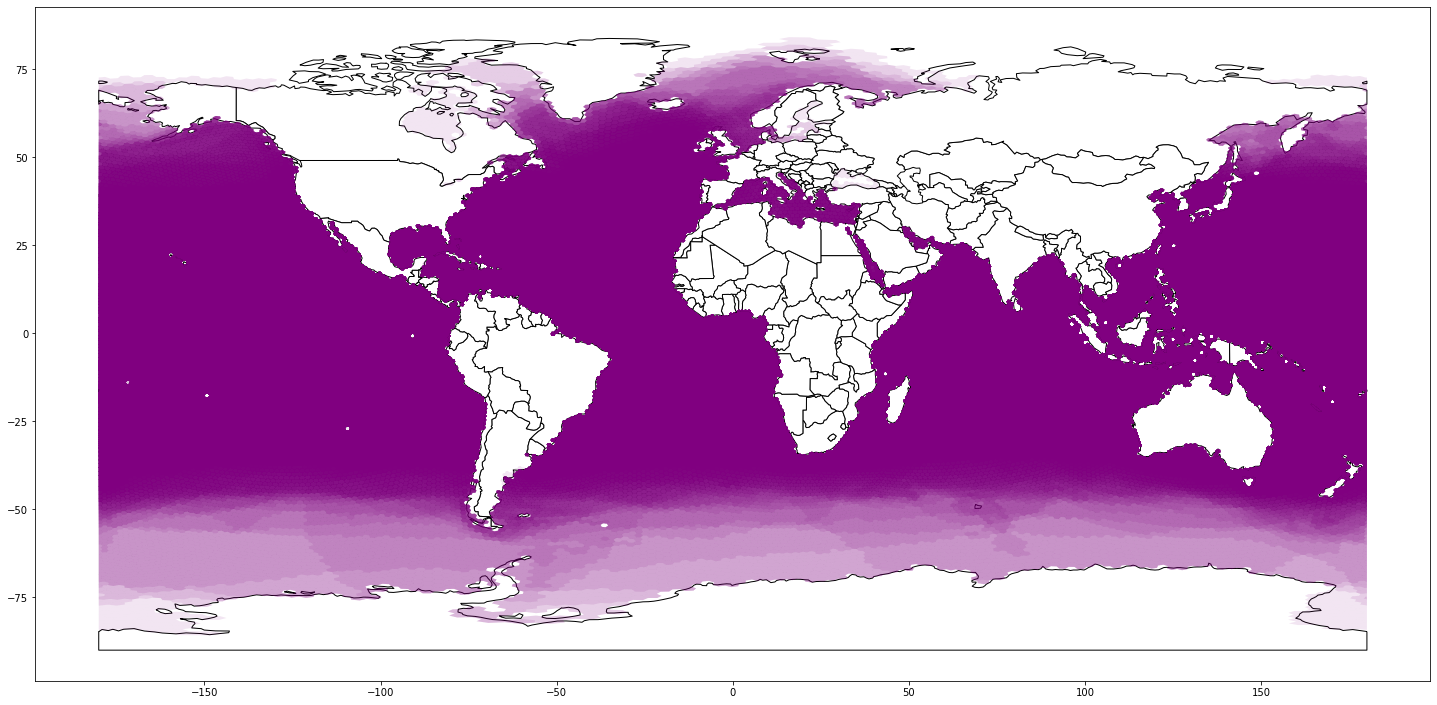

In [83]:
fig, ax = plt.subplots(figsize=(25, 25))

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')
df_h3.plot(ax=ax, alpha = 0.1, color = 'purple' )
# ax.set_xlim((-170, -190))
# ax.set_ylim((-20, 5))
plt.show();

In [ ]:
import folium
cr_basemap = folium.Map(location=[0, -180], tiles='CartoDB dark_matter' , zoom_start = 5)
df_h3.explore(
# temp.explore(
    m = cr_basemap,
    # column='val',
    # tooltip=['species','numobservations', 'individualcount', 'hfi', 'ppt_mean','tmax_mean', 'tmin_mean'],
    # # tooltip=['val'],
    highlight=True,
    popup=True, # show all values in popup (on click)
    tiles="CartoDB positron", # use "CartoDB positron" tiles
    cmap="jet", # use "Set1" matplotlib colormap
    categorical = False,
    style_kwds=dict(color="pink", stroke=True) # use black outline
)

In [ ]:
#Example code dissolve
# df_h3_final = df_h3_fixed.dissolve(level=0)
# df_h3_final

Uncomment to save

In [ ]:
#df_h3_final.to_file("AMMB_IUCN_h3.geojson", driver='GeoJSON')

### Now merge them

In [ ]:
final = df_h3.merge(AMMB_species, on='ID_NO', how='left')
final

In [ ]:
gdf = gpd.GeoDataFrame(final, crs="EPSG:4326", geometry=final.geometry_x).drop(['geometry_x','geometry_y'], axis=1)
gdf

In [ ]:
type(gdf)

In [ ]:
gdf.plot()